In [1]:
!nvidia-smi

Tue Oct  5 21:49:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   38C    P8    40W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [4]:
from model.models import AltCNN4Layer_D35_sp as Model
from model.collectdata import collect_data, collect_truth
from model.training import select_gpu
from model.plots import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize_state

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [5]:
device = select_gpu(-1)

Pick a file to load.

In [6]:
file = '/share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
validation = collect_data(file,
                          batch_size=1,
                          slice=slice(100),
                          masking=True,
                          device=device)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.08078 s
Constructing 100 event dataset took 0.005011 s


In [7]:
import h5py
XY_file = file

with h5py.File(XY_file, mode='r') as XY:
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [8]:
print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

6 6 13 6 24 34 12 24 12 11 24 12 6 6 0 6 0 6 11 0 23 11 6 18 6 6 6 12 12 17 12 6 12 17 17 23 12 0 12 23 24 6 12 34 12 9 24 23 5 0 6 12 6 12 18 30 12 36 18 6 0 16 23 6 18 12 6 18 5 6 24 0 6 23 18 18 0 12 6 35 30 6 12 6 24 6 18 12 12 18 11 6 6 6 18 6 12 24 18 16


In [9]:
PV = collect_truth(file, pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.009918 s
PV.n.shape =     (512,)
PV.n[0].shape =  8
PV.x[0] =        0.0304 -0.0165 -0.0365 -0.0144 -0.0121 0.0287 0.011 0.025
PV.y[0] =        -0.0098 -0.0196 -0.0109 0.0085 -0.0368 0.0152 -0.02 -0.0642
PV.z[0] =        15.7673 -72.0684 -34.512 49.1347 -62.7178 15.32 120.1546 14.7535
PV.n[0] =        122 15 37 0 25 65 33 93
PV.cat[0] =      1 1 1 -1 1 1 1 1


In [10]:
import h5py, awkward

In [11]:
x_list = []
y_list = []
z_list = []
n_list = []
c_list = []

p = 'p'

with h5py.File(file, mode='r') as XY:
    afile = awkward.persist.hdf5(XY)
    x_list.append(afile[f"{p}v_loc_x"])
    y_list.append(afile[f"{p}v_loc_y"])
    z_list.append(afile[f"{p}v_loc"])
    n_list.append(afile[f"{p}v_ntracks"])
    c_list.append(afile[f"{p}v_cat"])

print(x_list[0].JaggedArray)

<class 'awkward.array.jagged.JaggedArray'>


In [12]:
import awkward, h5py, numpy as np

simple = awkward.JaggedArray.fromcounts([2,3], [1.,2,3,4,5])

with h5py.File('example.h5', mode='w') as f:
    af = awkward.persist.hdf5(f)
    af['example'] = simple
    
with h5py.File('example.h5', mode='r') as f:
    af = awkward.persist.hdf5(f)
    example = af['example']
    
print(example.JaggedArray)

<class 'awkward.array.jagged.JaggedArray'>


In [13]:
with h5py.File(file, mode='r') as XY:
    schema = XY['pv_loc_x']['schema.json'].value

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [14]:
print(np.string_(schema))

b'{"awkward": "0.12.21", "schema": {"call": ["awkward", "JaggedArray", "fromcounts"], "args": [{"call": ["awkward", "numpy", "frombuffer"], "args": [{"read": "1"}, {"dtype": "int64"}, {"json": 512, "id": 2}], "id": 1}, {"call": ["awkward", "numpy", "frombuffer"], "args": [{"read": "3"}, {"dtype": "float64"}, {"json": 4158, "id": 4}], "id": 3}], "id": 0}, "prefix": "pv_loc_x/"}'


In [15]:
PV.n.flatten().max()

179

In [16]:
import awkward

In [17]:
PV.x

<JaggedArray [[0.0304 -0.0165 -0.0365 ... 0.0287 0.011 0.025] [0.0217 -0.039 -0.0206 ... 0.0109 -0.0289 -0.0127] [0.0125 0.0199 -0.0479 ... -0.0115 -0.017 -0.014] ... [-0.0099 0.0291 0.0198 ... 0.0463 -0.0629 -0.0195] [0.0193 -0.0204 0.0094 ... 0.0346 -0.0129 -0.0326] [-0.0188 0.0217 -0.0079 ... -0.0048 -0.0282 -0.0267]] at 0x7f9caac73d50>

In [18]:
PV.cat[0]

array([ 1,  1,  1, -1,  1,  1,  1,  1], dtype=int8)

In [19]:
SV = collect_truth(file, pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])

Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.0201 s
SV.n.shape =     (512,)
SV.n[0].shape =  238
SV.x[0] =        0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 0.0304 -0.0165 -0.0165 -0.0165 -0.0165 -0.0165 -0.0165 -0.0165 -0.0165 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0365 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0232 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 -0.0121 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.0287 0.028

In [20]:
model = Model().to(device)

Select a model to load. Make sure it matches the model you imported above.

> #### Mike note:
>
> If you use an old-style model, comment out the `d = modernize(d, 3)` line - that converts the old model key names to the new format.

In [21]:
state = torch.load(
    '/share/lazy/schreihf/PvFinder/models/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5/'
    '07Jan19_AltCNN4Layer_D35_sp_300epochs'
    '_240K_lr_3em5_bs256_Alt_Loss_A_5p5_199.pyt',
    map_location=torch.device('cpu')
)

In [22]:
del state['fc1.weight'], state['fc1.bias']

In [23]:
state = modernize_state(model, state)

In [24]:

model.load_state_dict(state)
model.eval()

AltCNN4Layer_D35_sp(
  (features): Sequential(
    (0): Conv1d(1, 25, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.05, inplace=False)
    (3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.05, inplace=False)
    (6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.05, inplace=False)
    (9): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.05, inplace=False)
    (12): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
    (13): Softplus(beta=1, threshold=20)
  )
)

Let's grab the outputs and labels as normal numpy arrays.

In [25]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

CPU times: user 3min 2s, sys: 2.75 s, total: 3min 5s
Wall time: 3.32 s


In [26]:
# fontdict = {
#     'font.size':18,
#     'font.weight':'bold'
# }

And here's Rui's plotting code.

nitems:  7
nitems:  6
nitems:  7
nitems:  6

Event 0: Found 7 of 7, added 0 (eff 100.00%)
nitems:  8
nitems:  8
nitems:  8
nitems:  8

Event 1: Found 7 of 8, added 1 (eff 87.50%)

Event 1.2:

PV: 7 tracks (type 1)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

SV: 1 tracks (type 0)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

SV: 1 tracks (type 0)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

SV: 1 tracks (type 0)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

SV: 1 tracks (type 0)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

SV: 1 tracks (type 0)
  x:    22 μm
  y:   -32 μm
  z:  -61.003 mm

07Jan19_AltCNN4Layer_D35_sp_00.pdf


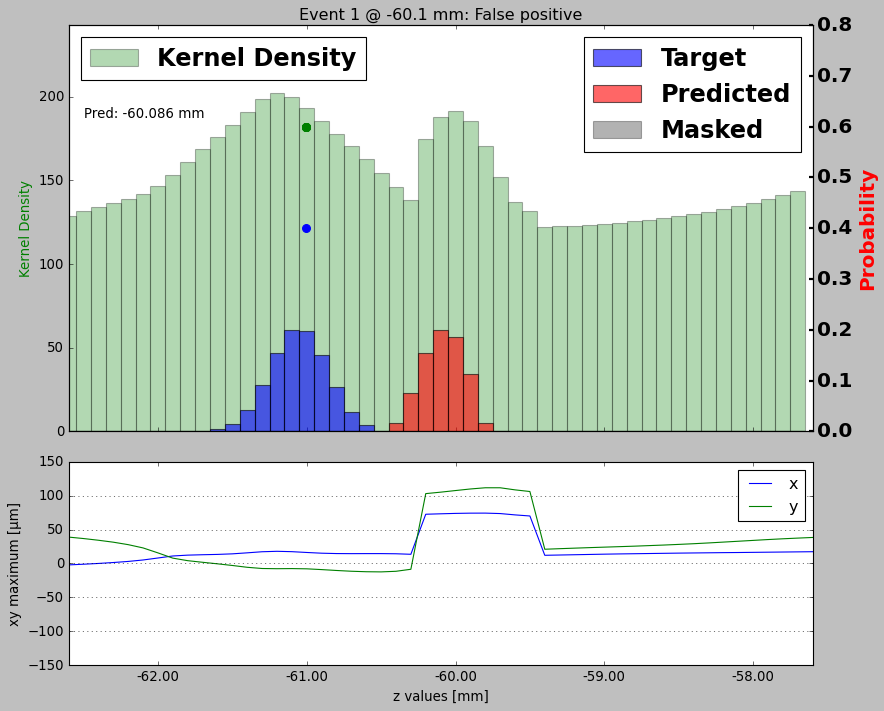

nitems:  5
nitems:  5
nitems:  5
nitems:  5

Event 2: Found 5 of 5, added 0 (eff 100.00%)
nitems:  2
nitems:  2
nitems:  2
nitems:  2

Event 3: Found 2 of 2, added 0 (eff 100.00%)
nitems:  6
nitems:  6
nitems:  6
nitems:  6

Event 4: Found 6 of 6, added 0 (eff 100.00%)
nitems:  9
nitems:  9
nitems:  9
nitems:  9

Event 5: Found 9 of 9, added 0 (eff 100.00%)
nitems:  7
nitems:  7
nitems:  7
nitems:  7

Event 6: Found 7 of 7, added 0 (eff 100.00%)
nitems:  8
nitems:  8
nitems:  8
nitems:  8

Event 7: Found 8 of 8, added 0 (eff 100.00%)
nitems:  7
nitems:  5
nitems:  7
nitems:  5

Event 8: Found 5 of 7, added 0 (eff 71.43%)
nitems:  2
nitems:  2
nitems:  2
nitems:  2

Event 9: Found 2 of 2, added 0 (eff 100.00%)
nitems:  7
nitems:  7
nitems:  7
nitems:  7

Event 10: Found 7 of 7, added 0 (eff 100.00%)
nitems:  4
nitems:  4
nitems:  4
nitems:  4

Event 11: Found 4 of 4, added 0 (eff 100.00%)
nitems:  7
nitems:  7
nitems:  7
nitems:  7

Event 12: Found 7 of 7, added 0 (eff 100.00%)
nitems: 

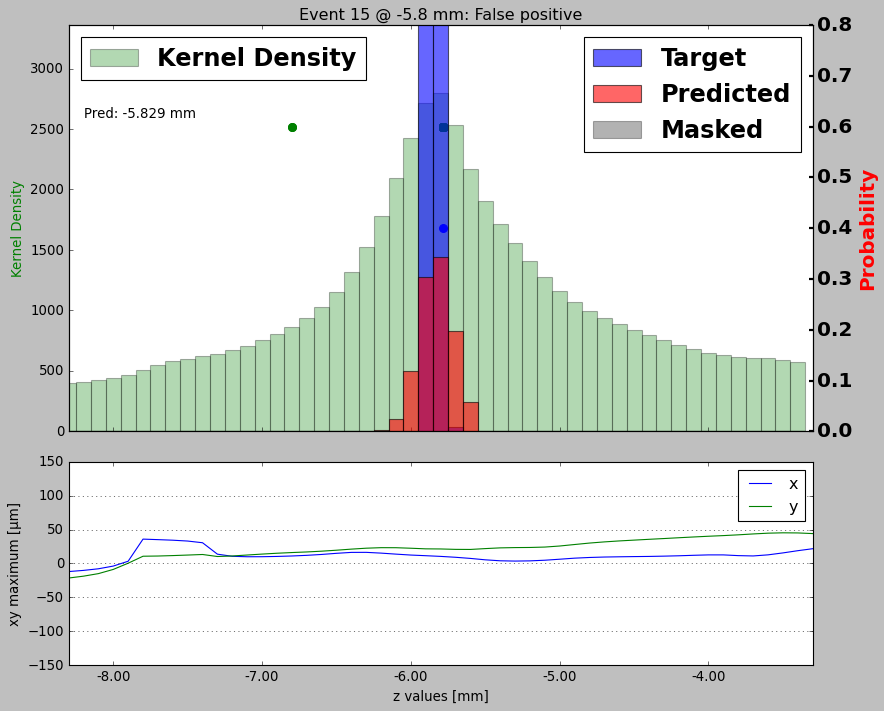

nitems:  7
nitems:  6
nitems:  7
nitems:  6

Event 16: Found 6 of 7, added 0 (eff 85.71%)
nitems:  7
nitems:  7
nitems:  7
nitems:  7

Event 17: Found 6 of 7, added 1 (eff 85.71%)


ValueError: max() arg is an empty sequence

In [27]:
inputs = validation.dataset.tensors[0].cpu().numpy().squeeze()
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = '07Jan19_AltCNN4Layer_D35_sp_{number:02}.pdf'
#  None # Or set: '120000_3layer_{number:02}.pdf'

for event in range(100):
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficenies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif np.any(np.isnan(label[i-3:i+3])):
            msg = 'Masked'
        else:
            msg = 'False positive'
            
        #with plt.style.context(fontdict):
        
            fig, axs = plt.subplots(2, figsize=(12,10), sharex=True,
                                    gridspec_kw={'height_ratios':[2,1],
                                                'hspace':0.1})
        
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            ax1, ax2 = plot_ruiplot(zvals, i, input, label, output, ax=axs[0])
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}"),
                          #fontdict=fontdict)


            msg = ""
            
            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = (comp_centroid[0] - truth_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot and print PVs
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
                    

            # Plot and print SVs
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            for x,y,z,n,cat in zip(SV.x[event], SV.y[event], SV.z[event], SV.n[event], SV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'SV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
            
            ax = axs[1]
            ax.plot((np.arange(4000) / 10) - 100, xmax[event]*1000000, label="x")
            ax.plot((np.arange(4000) / 10) - 100, ymax[event]*1000000, label="y")
            ax.set_xlim(ax1.get_xlim())
            ax.set_ylim(-150,150)
            ax.grid(axis='y')
            ax.set_ylabel('xy maximum [μm]')
            ax.legend(loc='best')
            
            ax.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            
            if output_filename:
                print()
                print(output_filename.format(number=internal_count))
            
            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count), transparent=True)
            plt.show()
            
            internal_count += 1
            
print(finalmsg)